# Visualizing Census Data

Statistically speaking, Nepal is a poor country. It ranks 180/222 in terms of GDP per capita [1](https://www.cia.gov/the-world-factbook/field/real-gdp-per-capita/country-comparison/), ranking well behind other post-conflict nations of Kosovo(132) and Laos (153). 76.2% of the adult population is literate [2](https://censusnepal.cbs.gov.np/results/literacy) and 41.9% of households sleep under roofs of galvanized tin sheets [3](https://censusnepal.cbs.gov.np/results/household).

<em>![Roofs](../img/roofs.png)Almost 42% of the Nation's populations lives in housing made out of galvanized steel. Source: 2021 Nepal Census</em>

However, such reality seems extremely far away in the capital city of Kathmandu where Teslas frequent the roads. Kathmandu's prosperity isn't new and stems from a list of historic and geographic factors. Situated at 4.6K ft above sea level, the Kathmandu valley is a large swath of fertile flatland in Himalayan Range where steep topography made agriculture very difficult[4](https://www.fao.org/4/t0706e/T0706E01.htm). Due to this geographic advantange, the region has been continously settled for at least 2000 years [5](https://www.nepalhikingteam.com/origin-of-kathmandu-valley). The large settlements attracted more people and soon Kathmandu found itself as an important trading hub, linking the India-Tibet land route [6](https://www.asiasocietymuseum.com/buddhist_trade/himalaya_nepal.html). Kings built roads, waterworks, and schools; merchants traded gold, spices and silk; while pilgrims spread art, region and philosophy. Consequentialy, Kathmandu and its residents grew rich while its surrounding countryside languished into subsistence farming.

We can see Kathmandu's regional dominance displayed clearly in its 2021 Census data[7](https://censusnepal.cbs.gov.np/results/downloads/ward?type=data). A comprehensive decinnial survey, the 2021 census is the most recent and most representative data on Nepal's socioeconomic factors. Key metrics such as number of households and their associated wealth quintile is present at the municipal ward level in excel format. While the data is not spatial, it is possible to use data cleaning methods to convert them. This report hence marks the first spatial exploration of the Nepal census data.

## Wrangling The Data

To begin my analysis, I first load the ward level shapefiles for Kathmandu valley into my environment. No public GIS data exists on political boundaries—however, in its absence, civillians have taken up charge on digitizing hence. All spatial files in this analysis is thanks to the hard work of Kiran Joshi, whose blog can be found [here](https://sites.google.com/view/maze215/home?authuser=0).

What is coloquially known as "Kathmandu" is in reality three cities. Legend says that three sons divided their father's kingdom into three parts to rule equally, creating the three cities of Kathmandu, Lalitpur, and Bhaktapur. But in spirit and in function, these cities work as one. Hence, my analysis will start by calling and combining the three shapefiles.

In [3]:
import geopandas as gpd
import pandas as pd

ktm = gpd.read_file('../data/sfs/Kathmandu/Kathmandu.shp')
bkt = gpd.read_file('../data/sfs/Bhaktapur/Bhaktapur.shp')
ltp = gpd.read_file('../data/sfs/Lalitpur/Lalitpur.shp')

cities = pd.concat([ktm, bkt, ltp])

#cleaning up the center columnm as it contains neighbourhood name information
cities['Center'] = cities['Center'].str.replace(' Office$', '', regex=True)

cities.head()

OBJECTID    State  State_Code   District  Protected      Mun_Name  \
0      3707  Bagmati           3  KATHMANDU        NaN  Gokarneshwor   
1      3708  Bagmati           3  KATHMANDU        NaN  Gokarneshwor   
2      3709  Bagmati           3  KATHMANDU        NaN  Gokarneshwor   
3      3710  Bagmati           3  KATHMANDU        NaN  Gokarneshwor   
4      3711  Bagmati           3  KATHMANDU        NaN  Gokarneshwor   

      Mun_Type                     Center  Area_SQKM  Ward_No  \
0  Nagarpalika  Gokarneshwor Municipality     7.0128        3   
1  Nagarpalika  Gokarneshwor Municipality     4.6919        4   
2  Nagarpalika  Gokarneshwor Municipality     1.0760        5   
3  Nagarpalika  Gokarneshwor Municipality     0.5591        6   
4  Nagarpalika  Gokarneshwor Municipality     1.3092        8   

                                            geometry  
0  POLYGON ((342664.728 3073511.945, 342660.154 3...  
1  POLYGON ((342803.560 3069107.750, 342787.801 3...  
2  POLYGON ((340158.801 3066905.027, 340126.624 3...  
3  POLYGON ((340531.184 3067725.024, 340535.003 3...  
4  POLYGON ((340879.585 3068658.365, 340889.756 3...

Next, I call and clean the Household Income dataset. After a bit of manipulation and cleaning, my final dataframe gives me ward level information on the total number of households, and the number of households that fall under each wealth quintile ranging from 1 to 5 with 1 being the most economically vulnerable households.

In [5]:
hhwealth = pd.read_excel('../data/census/HHwealth.xlsx')

#creating new names for income quartiles
colnnames = [
    'prov', 'dist', 'gapa', 'name', 'ward', 'tot_hh',
    'quart1_count', 'quart2_count', 'quart3_count', 'quart4_count', 'quart5_count',
    'quart1_%', 'quart2_%', 'quart3_%', 'quart4_%', 'quart5_%'
]

#dropping unnecesary values
hhwealth = hhwealth.iloc[3:].reset_index(drop=True)
hhwealth.columns = colnnames

#dataset contains random text values interrupting wards, hence removing such rows
numeric_columns = [col for col in hhwealth.columns if col != 'name']
for col in numeric_columns:
    hhwealth[col] = pd.to_numeric(hhwealth[col], errors='coerce')

#only selecting the observations for the three municipal districts
valhhwealth = hhwealth[hhwealth['dist'].isin([28, 29, 30])]

valhhwealth.head()

prov  dist  gapa                       name  ward  tot_hh  quart1_count  \
453     3    28     0                 Kathmandu    NaN  542892          2038   
454     3    28     1  Shankharapur Municipality   NaN    7140           376   
455     3    28     1  Shankharapur Municipality   1.0     867            83   
456     3    28     1  Shankharapur Municipality   2.0     426            65   
457     3    28     1  Shankharapur Municipality   3.0     589            36   

     quart2_count  quart3_count  quart4_count  quart5_count  quart1_%  \
453         11398         39406        175348        314702      0.38   
454           874          1676          2129          2085      5.27   
455           106           334           255            89      9.57   
456            98           161            69            33     15.26   
457            92           156           174           131      6.11   

     quart2_%  quart3_%  quart4_%  quart5_%  
453      2.10      7.26     32.30     57.97  
454     12.24     23.47     29.82     29.20  
455     12.23     38.52     29.41     10.27  
456     23.00     37.79     16.20      7.75  
457     15.62     26.49     29.54     22.24

As there are no spatial geometries present in the municipal data, we would want to join the census infomation to our ward-level map by the name of the municipality and their corresponding ward. But, having been phonetically converted to English, the municipalities are not spelled the same way across the dataset. Additionally, the data also contains unnecesary (and unstandardized) descriptors which will inhibit a join.

To address these issues, I remove all unneeded suffixes and match my datasets using a fuzzy criteria. Two neighbourhoods are considered the same if their names are up to 80% similar.

In [6]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

#helper function to clean unnecesary descriptors that don't add to the analysis
def clean_name(name):
    name = name.strip()
    suffs = [
        ' Municipality',
        ' Metropolitian City', 
        ' Metropolitan City',
        ' Mahanagarpalika',
        ' Nagarpalika',
        ' Nagarpalika VDC',
        ' Mun',
        ' Gabisa Karyalaya',
        ' Gabisa Bhawan',
        ' Gaunpalika',
        ' Sub Metro'
    ]
    clean = name
    for suffix in suffs:
        if clean.endswith(suffix):
            clean = clean[:-len(suffix)].strip()
    
    return clean

# Cleaning the column containing municipality information
cities['Municipality'] = cities['Mun_Name'].apply(clean_name)
valhhwealth['Municipality'] = valhhwealth['name'].apply(clean_name)

# fuzzy matching accoridng to cleaned names
def find_match(name, choices, min_score=80):
    best_match = process.extractOne(name, choices)
    if best_match and best_match[1] >= min_score:
        return best_match[0]
    return None

# creating a mapping column of fuzzy matched names
name_mapping = {}
for name in cities['Municipality'].unique():
    match = find_match(name, valhhwealth['Municipality'].unique())
    if match:
        name_mapping[name] = match

#adding those to the dataset
cities['new_name'] = cities['Municipality'].map(name_mapping)

# joining my census data to the spatial files
cities_inc = pd.merge(cities, 
                     valhhwealth,
                     left_on=['new_name', 'Ward_No'],
                     right_on=['Municipality', 'ward'],
                     how='left')

#finally, converting my data to WGS84
cities_inc = cities_inc.to_crs('EPSG:4326')

/var/folders/mm/m098rbs1529c7x072qh31ncw0000gn/T/ipykernel_13074/2053149582.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valhhwealth['Municipality'] = valhhwealth['name'].apply(clean_name)


Once the data has been joined, we can see Kathmandu's settlement patterns immediately by observing the distribution of houses. Here, wards near the center of the city have significantly higher number of households than wards comprising the surorunding hills. The large variance in values presents problem with scaling the data making visual observation difficult.

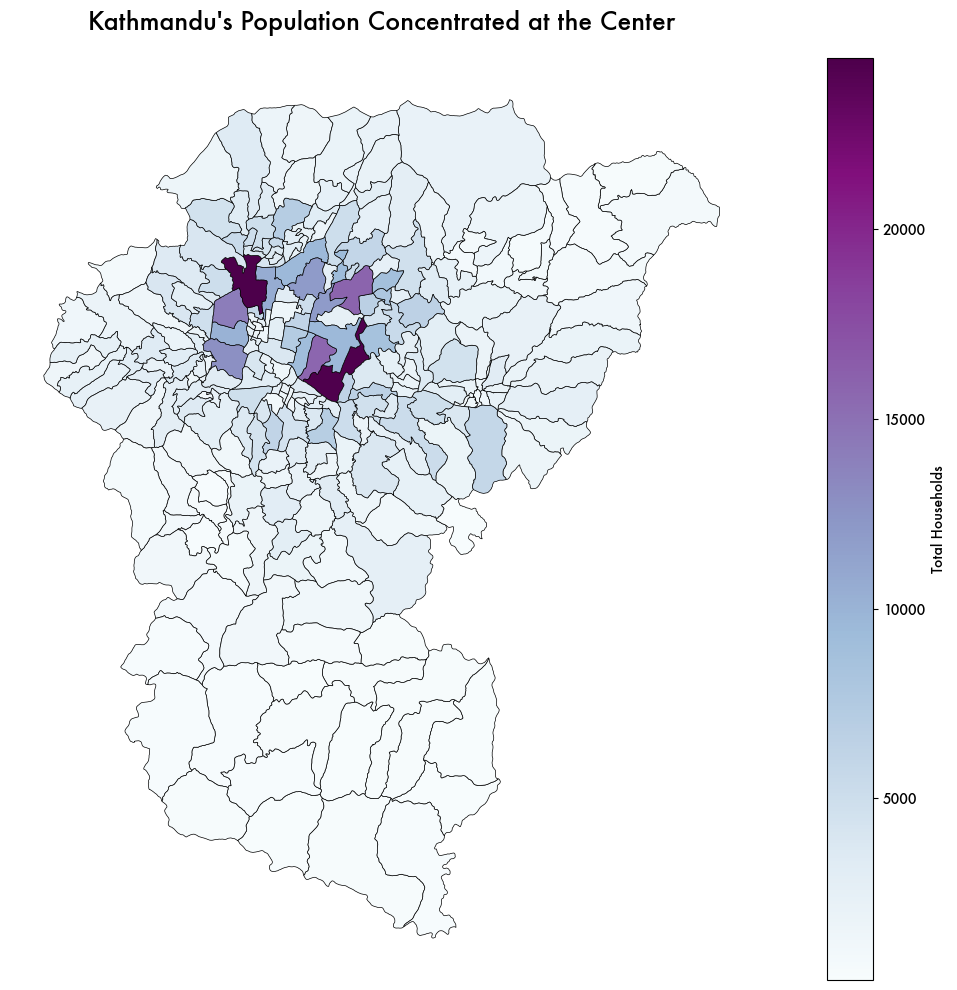

In [18]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_facecolor('ivory')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Futura']

plot = cities_inc.plot(ax=ax, 
    column='tot_hh',
    cmap='BuPu',
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    legend_kwds={'label': 'Total Households'}
)

ax.set_title("Kathmandu's Population Concentrated at the Center", 
    size=18, 
    pad=20
)
ax.set_axis_off()

plt.tight_layout()

One way to avoid the issue of large variance is by scaling the total number of households. The map below shows us the distribution of households (log scale) in Kathmandu where darker coloured wards corresponds to a higher concentration of houses. We are able to see the trend of increasing concentration near the city center much clearer in this map, though the issue of restricting city limits still remains.

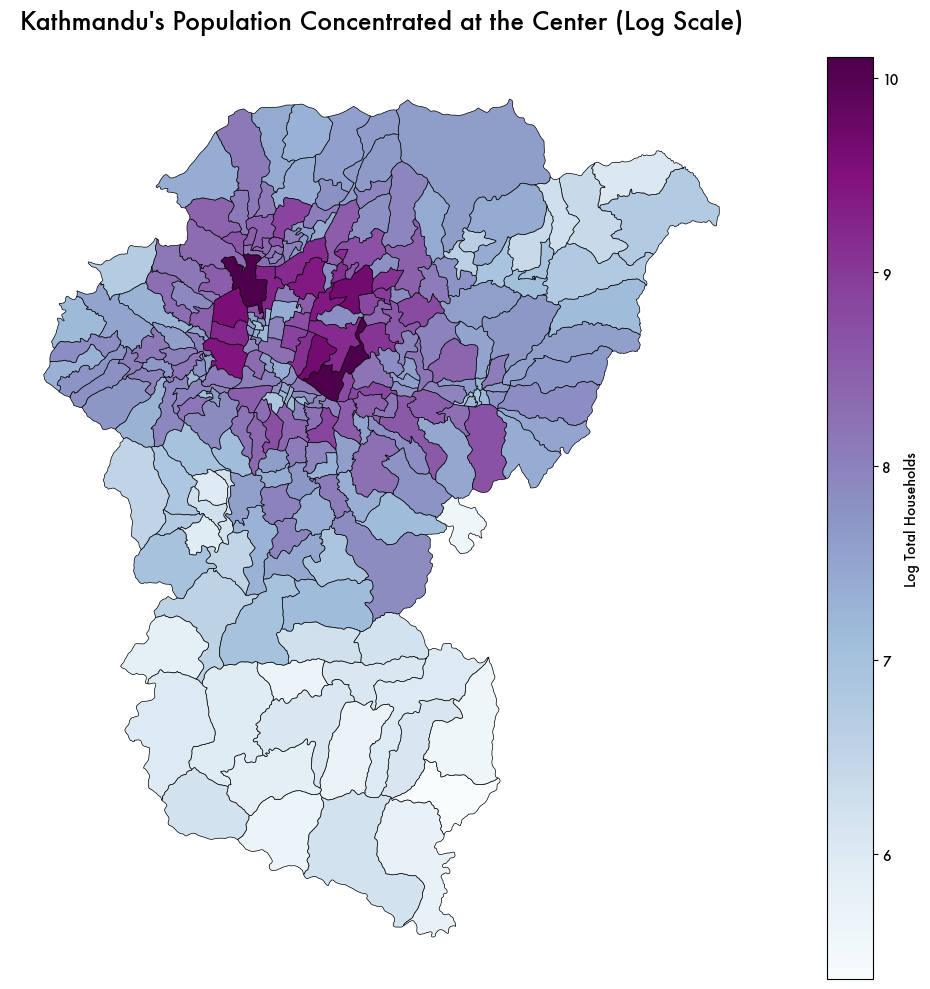

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_facecolor('ivory')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Futura']

cities_inc['log_hh'] = np.log(cities_inc['tot_hh'])
plot = cities_inc.plot(ax=ax, 
    column='log_hh',
    cmap='BuPu',
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    legend_kwds={'label': 'Log Total Households'}
)

ax.set_title("Kathmandu's Population Concentrated at the Center (Log Scale)", 
    size=18, 
    pad=20
)
ax.set_axis_off()

plt.tight_layout()

## Setting Limits for Kathmandu

Our analysis will not be very useful if we include sparsely populated hill wards in our dataset. Our study area needs to have tigther city limits—for this purpose I use a road density based selection criteria. Using road network data from Open Street Maps, I calculate the density of streets by area for each ward. I then filter out all wards who fall in the bottom 30th percentile for road density.

/opt/homebrew/Caskroom/mambaforge/base/envs/musa-550-fall-2023/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/Caskroom/mambaforge/base/envs/musa-550-fall-2023/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/homebrew/Caskroom/mambaforge/base/envs/musa-550-fall-2023/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/opt/homebrew/Caskroom/mambaforge/base/envs/musa-550-fall-2023/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/homebrew/Caskroom/mambaforge/base/envs/musa-550-fall-2023/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in

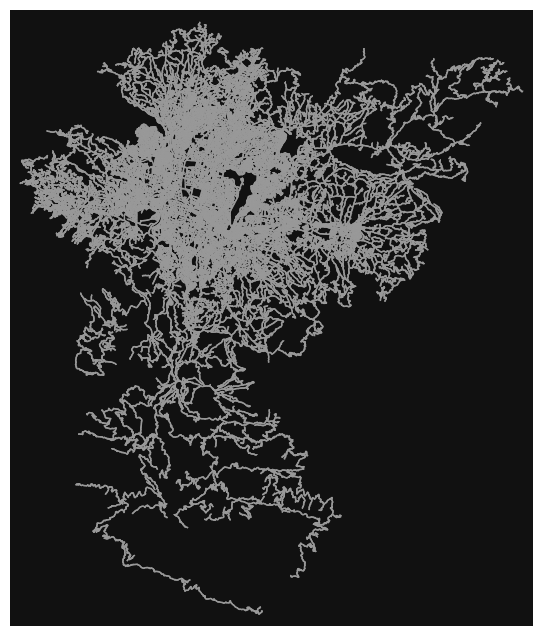

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
import osmnx as ox
valley = cities_inc.dissolve().make_valid()
street_network = ox.graph_from_polygon(valley.geometry.iloc[0], network_type="drive")
ox.plot_graph(ox.project_graph(street_network), node_size = 0)

Above, the map of the street network also presents a similar story of density, where the network is more concentrated in the North-Center area of the valley. Lets remove now all the less dense wards.

In [9]:
from shapely.geometry import Polygon

#getting street edges
edges = ox.graph_to_gdfs(street_network, edges = True, nodes = False).to_crs(cities_inc.crs)

#counting number of streets per ward
cities_inc['streetcount'] = cities_inc.geometry.apply(
    lambda x: len(edges[edges.intersects(x)])  
)

#creating density metric
cities_inc['streetdensity'] = cities_inc['streetcount']/cities_inc['Area_SQKM']

#selecting 30th quartile threshold
threshold = cities_inc['streetdensity'].quantile(0.30)

#subsetting values
main_city = cities_inc[cities_inc['streetdensity'] >= threshold]

In [36]:
#writing valley geojson
valley.to_file("../data/sfs/valley.geojson")

#writing cities geojson
main_city.to_file("../data/sfs/maincity.geojson")

The resulting map shows a much tighter city limits though the issues with scale still presists which we will address by logging the total number of households. Here, we see conspicous pockets of empty space surrounded by a growing belt of dense settlements. There are three empty cores—each corresponding to the historic city centers of Kathmandu, Lalitpur, and Bhaktapur.

/opt/homebrew/Caskroom/mambaforge/base/envs/musa-550-fall-2023/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


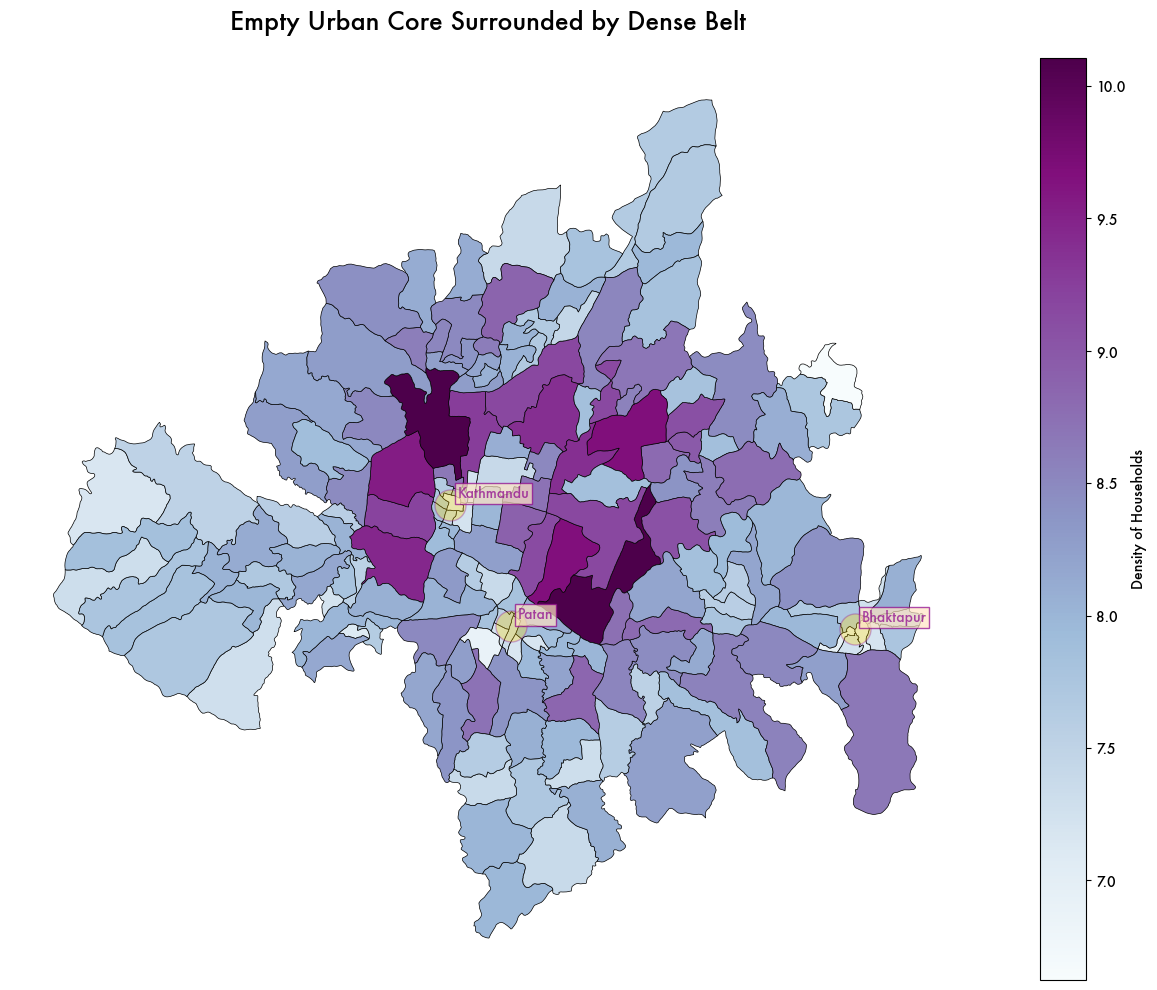

In [19]:
from shapely.geometry import Point
#  Creating a gdf of historic city center area
centers = gpd.GeoDataFrame(
    {
        'name': ['Kathmandu', 'Patan', 'Bhaktapur'],
        'geometry': [
            Point(85.30727341768024, 27.705040937390145),
            Point(85.32530690762836, 27.672831546274733),
            Point(85.42829510275436, 27.672202975996818)
        ]
    },
    crs='EPSG:4326'
)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_facecolor('ivory')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Futura']

main_city['log_hh'] = np.log(main_city['tot_hh'])

main_city.plot(ax=ax, 
    column='log_hh',
    cmap='BuPu',
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    legend_kwds={'label': 'Density of Households'}
)

centers.plot(ax=ax,
           color="gold",
           edgecolor='darkmagenta',
           alpha=0.3,
           markersize=500)  # Increase dot size

for idx, row in centers.iterrows():
   ax.annotate(row['name'], 
               xy=(row.geometry.x, row.geometry.y),
               color='darkmagenta',
               bbox=dict(
                  facecolor='bisque',
                  edgecolor='darkmagenta',
                  alpha=0.7,
                  pad=2
                  ),
               alpha=0.7,
               xytext=(5, 5), 
               textcoords='offset points')

ax.set_title("Empty Urban Core Surrounded by Dense Belt", 
    size=18, 
    pad=20
)
ax.set_axis_off()

plt.tight_layout()

The empty core areas on the map have long been the commerical and political center of Kathmandu. In the above map, the labeled areas corresponds to the historic districts of the three cities. These ancient city centers are a major draw for commerce and tourism, though I can see how their bustle and chaos would push away residential households.

<img src="../img/ktm.jpg" width="49%" style="display: inline-block"> <img src="../img/indra.jpg" width="49%" style="display: inline-block">

<p><em>The Historic Kathmandu Palace Complex and a nearby shopping square. These historic districts still contains shops and squares that have been present for centuries. A trip to Kathmandu is incomplete without a visit to at least one (but honestly all three) of these centers, though the age of some of these houses may make them uncomfortable to live in long term.</em>

The settlement pattern of Kathmandu also visually corresponds to the "donut-shaped" city—declining and empty city centers surrounded by a growing residential belt. While the city centers are still important hubs of commerce, housing stock in these areas are old, cramped, and lack modern amenities. As a result, buildings in this area is increasingly converted to solely commerical units while families move to more spacious (and modern) homes in the residential belt.

## Where do the Rich Live?
Urban theory suggests that people living in these residential belts are likely to be wealthier than their peers. However, spatial distribution in Kathmandu is unlikely to be uniform. Even in the residential belt, some wards are going to have a higher concentration of rich households than others. In this section, we seek to understand the distribution of households by their wealth quintiles in the city. 

First, we need to understand how the ward polygons correspond to the actual map of the city. Using the folium library, I created a map where users can toggle layers of highest and lowest income quartiles over the OSM layout of the city.

In [131]:
import folium
m = main_city.explore(
    column='quart5_%',
    legend=True,
    cmap='viridis',
    name='Highest Income',
    tooltip=['name', 'ward', 'quart5_%', 'quart4_%', 'quart3_%', 'quart2_%','quart1_%']
)
main_city.explore(
    column='quart1_%',
    cmap='inferno',
    name='Lowest Income',
    m=m ,
    tooltip=['name', 'ward', 'quart5_%', 'quart4_%', 'quart3_%', 'quart2_%','quart1_%']
)

folium.LayerControl().add_to(m)

m

From this map, we are able to derive the following insights: 

* Ward 5 (known locally as Lagankhel) of Lalitpur has the highest concentration of wealthy households in the city. This makes sense considering the social context of the city. This area is home to a lot of INGOs and their very well-paid staff. Additionally, out of the three cities, Lalitpur is known to be the wealthiest with an almost 100% adult literacy rate. 

* In the periphery of the city, Ward 1 of Nagarjun and Wards 1,2,and 4 of Kathmandu also show significant concentration of wealth. While the wards of Kathmandu are already known locally as being wealthy, the high concentration of wealthy households in Nagarjun stands out as that area is far to the city outskirts. However, this makes sense considering the growing suburban trend of Kathmandu. 

* Areas near the historic palace complexes have the lowest incidence of high income households in the city, underscoring our observations of declining urban core. 

* Distribution of lowest quantiles doesn't tell us much due to the high variance of wealth in Nepal. Residents who are wealthy outside the valley may find themselves struggling in the city due to high living costs. Hence, lower wealth quintiles are unlikely to be represented in such scale in the city. However, we do notice that presence of households in the lowest quantile increases rapidly once we enter the hills in the western parrt of the city.

To study the distribution of household wealth, I create an interactable visualization using hvplot. Now, we can toggle between various economic quintiles and see their distribution. One key thing we notice from this new visualization is regarding our assumption about the relative prosperity of the valley. The lowest 2 quartiles are virtually unrepresented in the valley, with the concentration only increasing starting from quartile 3, or the middle income quartile. 

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
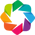

/opt/homebrew/Caskroom/mambaforge/base/envs/musa-550-fall-2023/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/Caskroom/mambaforge/base/envs/musa-550-fall-2023/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/homebrew/Caskroom/mambaforge/base/envs/musa-550-fall-2023/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/Caskroom/mambaforge/base/envs/musa-550-fall-2023/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/Caskroom/mambaforge/base/envs/musa-550-fall-2023/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/

BokehModel(combine_events=True, render_bundle={'docs_json': {'d86dd92a-50e9-4eb1-b869-e76db3dd1255': {'version…

In [33]:
import hvplot.pandas
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

plot1 = main_city.melt(
    id_vars=["OBJECTID", "geometry"],
    value_vars=['quart5_%', 'quart4_%', 'quart3_%', 'quart2_%','quart1_%'],
    var_name="Quintile",
    value_name="Percentage"
)


plot1.hvplot(geo=True, 
             c='Percentage', 
             alpha=0.45, 
             groupby='Quintile',
             widget_location='left_top',
             color_key='viridis',
             tiles='OSM')

### Estimating Income Distribution

Though the census data doesn't provide us with information on median household income, it is possible to estimate this data using other publicly available government data. The National Statistics Office has information on the median and mean income values for each quartile on their [website](https://data.nsonepal.gov.np/dataset/b6c3c19b-4b15-44bf-8653-1571e76dad14/resource/d711c2a1-2f5c-47a6-be02-bb4073fe234d?inner_span=True). 

I used this information to come up with weighted estimates of median income for each ward using the proportion of quantile distribution. 

In [26]:
plot2 = main_city.copy()

med_inc = {
    'quart1': 242797,  
    'quart2': 299341,  
    'quart3': 377000,
    'quart4': 465301,  
    'quart5': 617882  
}

plot2['Est Income'] = (
    plot2['quart1_count'] * med_inc['quart1'] +
    plot2['quart2_count'] * med_inc['quart2'] +
    plot2['quart3_count'] * med_inc['quart3'] +
    plot2['quart4_count'] * med_inc['quart4'] +
    plot2['quart5_count'] * med_inc['quart5']
) / plot2[['quart1_count', 'quart2_count', 'quart3_count', 
        'quart4_count', 'quart5_count']].sum(axis=1)


plot2['Est Income'] = pd.to_numeric((plot2['Est Income'])/100000).round(1)

Plotting the results gives me the following graph showing the distribution of estimated annual income. Here, income is given in 100k NRP per year, roughly equivalent to $735 USD. From the map, we can see two rings of high income wards surrounding the empty urban cores of Kathmandu and Lalitpur. Key feature to note is the double layer of residential settlements with a high income ring just surrounding the empty urban core, and an middle income ring wrapping at the very outskirts. Once, again, this typology corresponds to the Chicago Concentric Ring Theory of Urban Planning.

In [29]:
import altair as alt

alt.Chart(plot2).mark_geoshape(
    stroke='white',
    strokeWidth=0.5
).encode(
    color=alt.Color('Est Income:Q', 
        scale=alt.Scale(scheme='plasma'),
        title='Annual Income (Lakhs NRP)'),
    tooltip=['Mun_Name:N', 'ward:N','Est Income:Q']
).properties(
    width=800,
    height=600,
    title='Two Rings of High Income Settlements in the City'
)

alt.Chart(...)

## Where do the Poor Live?
Kathmandu is a mixed-income city where the rich live alongside (sometimes as stay-in landlords of) the poor. However, this does't mean that every ward in the city is made up of the same composition of households. Some will be more well off compared to others. 

However, the information provided by the census doesn't help much to mapping poverty in the context of Kathmandu. To address the issues outilned above, I combined the proportion of the lowest 3 quartiles to make a single "Low Income" catagory fo the city. 

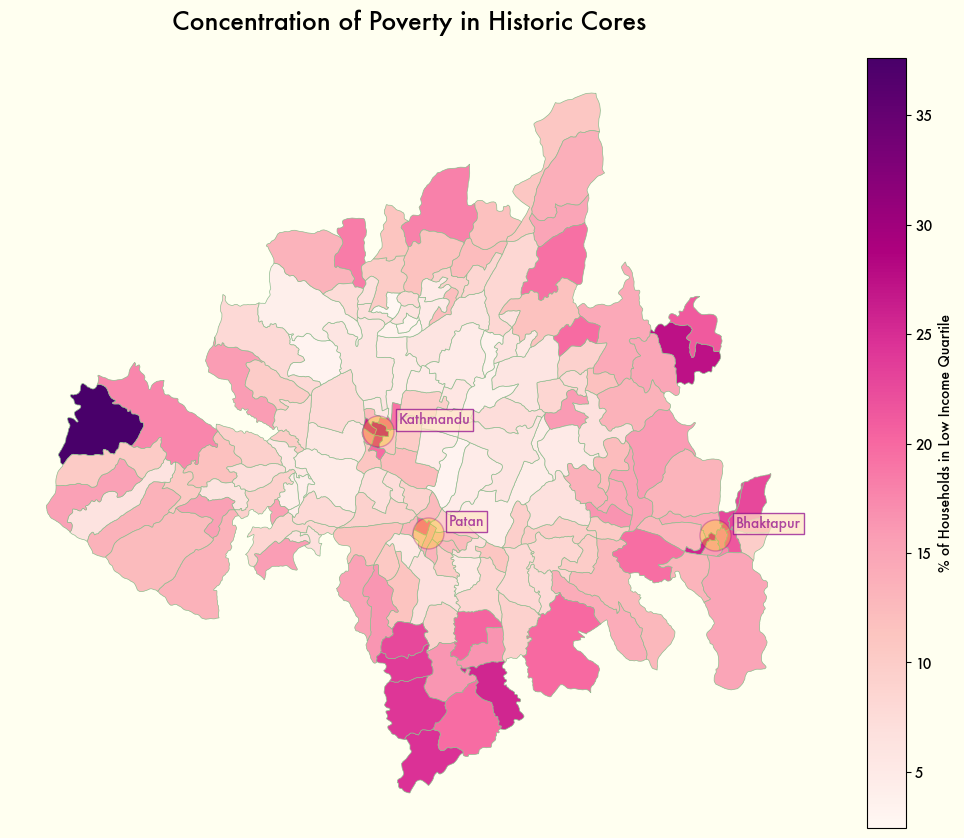

In [12]:
plot3 = main_city.copy()
plot3['Low Income'] = plot3[['quart1_%', 'quart2_%', 'quart3_%']].sum(axis=1)

fig, ax = plt.subplots(figsize=(15, 10), facecolor='ivory')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Futura']

plot3.plot(ax=ax, column='Low Income', 
          cmap='RdPu',
          edgecolor='darkseagreen',
          linewidth=0.5,
          legend=True,
          legend_kwds={'label': '% of Households in Low Income Quartile',
                      'orientation': 'vertical'}) 



centers.plot(ax=ax,
           color="gold",
           edgecolor='darkmagenta',
           alpha=0.3,
           markersize=500) 

for idx, row in centers.iterrows():
   ax.annotate(row['name'], 
               xy=(row.geometry.x, row.geometry.y),
               color='darkmagenta',
               bbox=dict(
                  facecolor='bisque',
                  edgecolor='darkmagenta',
                  alpha=0.7,
                  pad=2
                  ),
               alpha=0.7,
               xytext=(15, 5), 
               textcoords='offset points')

ax.set_title("Concentration of Poverty in Historic Cores", 
    size=18, 
    pad=20
)
ax.set_axis_off()

Unsurprisingly, the distribution of low income households is the inverse of the income distribution map. Here, the center and the periphery shows a higher concentration of low income households.